In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

In [3]:
def identity(x):
    return x

def relu(x):
    
    # One line return statement is dope!
    return np.where(x > 0, x, 0)

def l_relu(x, a = 0.01):
    
    # One line return statement is dope!
    return np.where(x > 0, x, a*x)

def sine(x):
    
    return np.sin(x)

def tanh(x):
    return np.tanh(x)

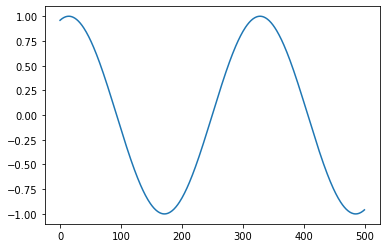

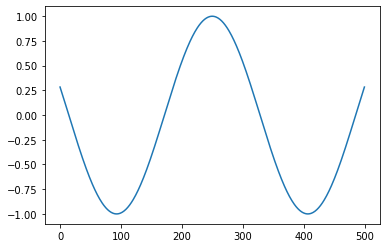

In [4]:
# Experimental: Yield the approximation of the derivative of function f at point x
def get_derivative(f, x, offset = 0.01):
    
    # Define points between which derivative is approximated
    vec1 = np.array([x - offset, f(x - offset)])
    vec2 = np.array([x + offset, f(x + offset)])
    
    # Get the vector between the two points
    sub = vec2 - vec1
    
    # Return the slope (rise over run echoes in your head)
    return sub[1]/sub[0]


activation = sine
# Method used for mapping multiple values to the get_derivative method.
def test_approximation(x):
    return get_derivative(activation, x)

line = np.linspace(-5, 5, num = 500)


plt.plot(list(map(activation, line)))
plt.show()
plt.plot(list(map(test_approximation, line)))
plt.show()

# Loss functions

In [6]:
def MSE(y_p, y_t):
    
    
    error = np.square(y_p - y_t) * 1/(2 * len(y_p))
    
    d_error = 2 * (y_p - y_t) * 1/len(y_p)
        
    return np.nan_to_num(error), np.nan_to_num(d_error)

#def meta_cluster():

MSE(np.array([1, 1]), np.array([2, 3]))

(array([           0.250,            1.000]),
 array([          -1.000,           -2.000]))

# Layer classes


In [8]:
# Super class of layers
class Layer(object):
    
    def __init__(self):
        
        self.signal = None
        self.derivative = None
        self.error = None
        self.gradient = []
        self.activation = identity
        
    def get_params(self):
        return None
        
    
class graph:
    
    def __init__(self, size, activation = identity, iters = 2, W = None):
        
        if W == None:
            size = (size, size + 1)
            self.W = np.random.random_sample(size) - 0.5
        else:
            self.W = W
        
        self.activation = activation
        self.iters = iters
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp
        for i in range(self.iters):
            # Append bias
            inp = np.append(inp, 1)
            inp = self.activation(self.W.dot(inp))
        
        return inp
    
        
class scaling(Layer):
    def __init__(self, scalar = None):
        
        self.scalar = scalar
        
    def get_params(self):
        return self.scalar
    
    def feed_forward(self, inp, train = True):
            
        self.signal = inp
        if self.scalar == None:
            return inp * 1/np.max(np.abs(inp))
            
        return inp * self.scalar
    
    
class dropout:
    
    def __init__(self, rate = 0.1):
        
        self.rate = rate
        
    def get_params(self):
        return self.rate   
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp
        
        if train == False:
            # Only drop on train
            return inp
    
        mask = np.random.random_sample(inp.shape)
        
        mask = np.where(mask > self.rate, 1, 0)
        
        return np.multiply(inp, mask)

    
class fullyConnected(Layer):
    def __init__(self, size, activation = identity, W = None):
        
        if W == None:
            size = (size[0], size[1]+1)
            self.W = np.random.random_sample(size) - 0.5
        else:
            self.W = W
        
        self.activation = activation
        
        self.gradients = []
    
    def approximate_derivative(self, x):
        return get_derivative(self.activation, x)
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        # Append bias
        inp = np.append(inp, 1)
        
        self.signal = inp
        
        if train:
            self.derivative = list(map(self.approximate_derivative, self.W.dot(inp)))
            self.derivative = np.array(self.derivative).T
        
        return self.activation(self.W.dot(inp))
    
    
    def compute_gradient(self, err, prev_input):
        
        
        error = err.reshape(len(err), 1) * self.W
        #print(error.shape)
        error = error * self.derivative.reshape(len(self.derivative), 1)
        error = np.sum(error, axis = 0)
        
        # Remove error of bias node
        error = error[:-1]
        #print("e1", error.shape, prev_input.shape)
        
        # Reshape prev_input to allow for dot product
        prev_input = prev_input.reshape(1, len(prev_input))
        
        # Error reshape is done here, it must not have the reshape when returning it!
        # Only the gradient requires this shape of error
        gradient =  error.reshape(len(error), 1).dot(prev_input)
        
        return (error, gradient)
        
    def update(self, alpha):
        
        for gradient in self.gradients:
            self.W -= alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [80]:
class Model:
    
    def __init__(self, layers = None):
        
        if layers == None:
            self.layers = []
            
        else:
            self.layers = layers
            
        self.history = {
            "error" : [],
            "acc" : []
        }
        
    def add(self, layer):
        
        self.layers.append(layer)
    
    # Admin methods (training algorithm, optimization)
    
    # Feed forward, save the derivatives and such
    def compute(self, x):
        
        for layer in self.layers:
            x = layer.feed_forward(x, train = True)
        return x
        
    
    def compute_gradient(self, x, y):
        
        gradient = None
        
        pred = self.compute(x)
        
        # Compute Error
        out_derivative = self.layers[-1].derivative
        Error, error_derivative = MSE(pred, y)
        print("Error:",Error)
        # Calculate gradient
        
        # First step
        
        error = error_derivative #* out_derivative

        # signal is the input signal of the layer, we propagate backwards now
        signal_n = self.layers[-1].signal
        gradient = error.reshape(len(error), 1) * signal_n.reshape(1, len(signal_n))
        self.layers[-1].gradients.append(gradient)

        # Second step, continuing backwards through the complete structure
        for i in reversed(range(1, len(self.layers))):
            
            # Sanity check variables
            layer = self.layers[i]
            prev_signal = self.layers[i-1].signal
            
            # Use specified method for computing the gradient
            error, gradient = layer.compute_gradient(error, prev_signal)
            self.layers[i-1].gradients.append(gradient)
        return Error
        
    def update_layers(self, alpha = 0.0003):
        
        for layer in self.layers:
            layer.update(alpha)
    
    
    # Train on batch x with labels y, this runs for one epoch. Both inputs must be iterables!
    def batch_update(self, x, y, alpha = 0.0003):
        
        
        errors = []
        
        # For all examples in batch
        for i in range(len(x)):
            
            e = self.compute_gradient(x[i], y[i])
            
            # Store statistics of the batch
            errors.append(e)

        
        # Update the layers once the gradients have been stored
        self.update_layers(alpha)
        
        return errors
        
    def train(self, x, y, epochs = 3, batch_size = 1, alpha = 0.0003, shuffle = True):
        
        
        for e in range(epochs):
            print("epoch:", e)
            index = 0
            errors = []
            
            # Shuffle the dataset
            if shuffle:
                
                shuffle_index = np.random.shuffle(np.arange(len(x)))
                
                x = x[shuffle_index][0]
                y = y[shuffle_index][0]
                
            
            while index < len(x):
                batch_examples = x[index : index + batch_size]
                batch_labels = y[index : index + batch_size]
                
                errors.append(self.batch_update(batch_examples, batch_labels, alpha))
                
                index = index + batch_size
                
            self.history["error"].append(np.mean(errors, axis = 0))
                
            
        
        
    # End-user methods
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.feed_forward(x, train = False)
        return x

    
    
np.random.seed(0)
model = Model()
inp_size = 50
model.add(fullyConnected((1, inp_size), activation = relu))
#model.add(fullyConnected((10, 10), activation = sine))
#model.add(fullyConnected((10, 6), activation = relu))
#model.add(scaling())
#model.add(dropout(rate = 0.2))
#model.add(graph(6, activation = tanh, iters = 3))
#model.add(fullyConnected((1, 10), activation = relu))




In [81]:
x = np.multiply(np.random.random_sample((300, inp_size)), np.random.random_integers(0, 5))
y = np.sum(x, axis = 1)
print(x[0].shape, y[0])

model.train(x, y, alpha = 0.003, batch_size= 50, epochs = 10)

for i, j in zip(x, y):
    p = model.predict(i)
    print(p, j, (p-j) * (p-j))

"""
errors = []
for i in range(len(x)):
    pred = model.predict(x[i])
    #print("Model, out_signal:", model.layers[-1].W.dot(np.append(x, 1)))
    print("pred:", pred)
    print("True_", y[i])
    if sum(pred) == 0:
        print(model.layers[-1].gradients)
    
    errors.append(np.sum(model.compute_gradient(x[i], y[i])))
    model.update_layers(alpha = 0.003)
    print()
    #print(model.layers[-1].gradients)
print(np.argmin(errors))
print(y[0])

plt.plot(errors)

plt.show()
"""

c:\users\joels\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
  """Entry point for launching an IPython kernel.


(50,) 102.4437390192653
epoch: 0
Error: [        4405.168]
Error: [        9424.797]
Error: [        6438.836]
Error: [        5830.350]
Error: [        9642.725]
Error: [        5289.212]
Error: [        7326.197]
Error: [        6318.802]
Error: [        7344.990]
Error: [        6899.441]
Error: [        7972.949]
Error: [        8115.185]
Error: [        5914.018]
Error: [        6037.016]
Error: [        6826.054]
Error: [        7198.238]
Error: [        8426.913]
Error: [        6171.054]
Error: [        7725.150]
Error: [        6234.931]
Error: [        6561.975]
Error: [        6351.759]
Error: [        7715.861]
Error: [        6976.466]
Error: [        8709.066]
Error: [        9048.859]
Error: [        8198.365]
Error: [        6242.904]
Error: [        7845.073]
Error: [       10179.128]
Error: [        7813.016]
Error: [        7789.339]
Error: [        7339.812]
Error: [        4887.783]
Error: [        8398.671]
Error: [        8202.419]
Error: [        6801.056]
Error

Error: [         624.759]
Error: [         306.193]
Error: [         228.353]
Error: [         258.883]
Error: [         221.327]
Error: [         236.754]
Error: [         103.698]
Error: [         329.341]
Error: [         269.447]
Error: [         256.255]
Error: [         375.613]
Error: [         168.907]
Error: [         171.896]
Error: [         175.142]
Error: [         200.794]
Error: [         267.017]
Error: [         167.487]
Error: [         245.381]
Error: [         111.756]
Error: [         158.151]
Error: [         152.738]
Error: [         233.109]
Error: [         133.951]
Error: [         285.281]
Error: [         118.730]
Error: [         226.792]
Error: [         326.908]
Error: [         320.924]
Error: [          81.941]
Error: [         263.147]
Error: [         110.389]
Error: [         412.602]
Error: [         275.428]
Error: [         224.018]
Error: [         260.211]
Error: [         221.683]
Error: [         284.092]
Error: [         119.736]
Error: [    

Error: [          40.718]
Error: [          10.751]
Error: [           4.666]
Error: [          23.080]
Error: [          31.329]
Error: [          15.426]
Error: [           3.516]
Error: [           3.012]
Error: [          19.694]
Error: [           4.216]
Error: [           0.445]
Error: [          22.641]
Error: [           7.817]
Error: [          33.398]
Error: [           2.269]
Error: [          13.836]
Error: [           3.917]
Error: [          19.794]
Error: [          17.292]
Error: [           0.017]
Error: [          15.724]
Error: [           6.165]
Error: [           8.446]
Error: [           7.386]
Error: [           2.519]
Error: [           3.371]
Error: [           0.112]
Error: [          42.688]
Error: [           7.061]
Error: [          12.271]
Error: [           3.817]
Error: [           3.335]
Error: [           3.554]
Error: [           5.539]
Error: [           6.642]
Error: [          32.024]
Error: [           0.532]
Error: [           0.066]
Error: [    

Error: [          61.177]
Error: [          22.916]
Error: [          26.396]
Error: [          50.257]
Error: [          57.693]
Error: [          68.874]
Error: [          41.266]
Error: [          81.602]
Error: [          35.079]
Error: [         103.130]
Error: [          35.626]
Error: [          58.659]
Error: [          63.481]
Error: [          42.922]
Error: [          13.731]
Error: [         110.968]
Error: [          39.717]
Error: [          40.786]
Error: [          11.869]
Error: [          37.581]
Error: [          26.152]
Error: [          33.579]
Error: [          32.945]
Error: [          22.788]
Error: [         117.566]
Error: [          23.932]
Error: [          48.521]
Error: [           8.407]
Error: [          11.530]
Error: [          17.807]
Error: [          27.342]
Error: [          58.683]
Error: [          61.663]
Error: [          77.368]
Error: [          72.864]
Error: [          50.241]
Error: [          18.915]
Error: [          37.186]
Error: [    

Error: [          29.702]
Error: [          12.798]
Error: [          16.229]
Error: [          60.444]
Error: [          18.528]
Error: [          44.798]
Error: [          12.562]
Error: [          35.079]
Error: [           4.860]
Error: [          27.153]
Error: [           4.317]
Error: [          42.894]
Error: [          71.308]
Error: [          50.763]
Error: [           7.932]
Error: [          40.052]
Error: [          41.447]
Error: [          23.321]
Error: [          45.381]
Error: [          34.460]
Error: [          35.241]
Error: [          16.464]
Error: [          13.645]
Error: [          13.453]
Error: [          28.993]
Error: [          45.335]
Error: [          32.178]
Error: [          61.361]
Error: [          15.676]
Error: [           3.640]
Error: [          27.208]
Error: [           4.577]
Error: [          53.861]
Error: [          24.688]
Error: [          12.487]
Error: [          24.636]
Error: [          27.237]
Error: [          44.496]
Error: [    

Error: [          34.100]
Error: [           4.128]
Error: [          15.764]
Error: [          20.523]
Error: [          39.801]
Error: [          40.370]
Error: [          39.938]
Error: [          14.083]
Error: [          26.629]
Error: [          54.222]
Error: [           8.577]
Error: [          33.977]
Error: [          14.126]
Error: [          21.693]
Error: [           1.621]
Error: [          11.936]
Error: [          35.736]
Error: [           6.115]
Error: [          24.185]
Error: [          17.245]
Error: [          32.567]
Error: [          51.321]
Error: [          12.333]
Error: [          12.692]
Error: [          25.275]
Error: [          59.943]
Error: [          44.925]
Error: [          25.799]
Error: [          34.358]
Error: [          47.456]
Error: [          17.656]
Error: [           0.198]
Error: [          27.467]
Error: [          50.500]
Error: [          30.667]
Error: [          51.825]
Error: [          25.861]
Error: [          23.774]
Error: [    

Error: [           8.210]
Error: [           0.930]
Error: [           6.437]
Error: [           6.157]
Error: [           1.794]
Error: [          20.032]
Error: [          20.499]
Error: [           8.798]
Error: [           7.346]
Error: [           0.064]
Error: [          14.601]
Error: [           7.719]
Error: [          10.918]
Error: [           2.771]
epoch: 9
Error: [          11.154]
Error: [           6.066]
Error: [           8.850]
Error: [          10.786]
Error: [           1.951]
Error: [           2.057]
Error: [          22.106]
Error: [           7.729]
Error: [          19.206]
Error: [           2.030]
Error: [           7.856]
Error: [           0.226]
Error: [           9.655]
Error: [           0.510]
Error: [          12.417]
Error: [          22.608]
Error: [          15.703]
Error: [           1.786]
Error: [          10.382]
Error: [          15.002]
Error: [           5.659]
Error: [          23.000]
Error: [          10.361]
Error: [          12.811]
Err

[         128.893] 126.67057914516403 [           4.940]
[         112.613] 108.94856102679113 [          13.427]
[         142.550] 137.65084590968533 [          23.997]
[         114.957] 114.00649883084837 [           0.903]
[         110.569] 109.0014775512495 [           2.457]
[         129.473] 125.7816847670698 [          13.625]
[         113.790] 113.06157090636077 [           0.530]
[         128.843] 125.90227222747286 [           8.645]
[         123.901] 125.2127790871138 [           1.720]
[         120.749] 119.28980039300792 [           2.128]
[         119.900] 117.80474794223437 [           4.391]
[         130.152] 126.38733616226023 [          14.172]
[         131.054] 127.83463408873799 [          10.362]
[         129.475] 126.16423736298428 [          10.960]
[         121.471] 120.67555061429499 [           0.632]
[         125.979] 123.79691110104173 [           4.763]
[         134.929] 130.64942149228247 [          18.316]
[         119.168] 118.99552807795

'\nerrors = []\nfor i in range(len(x)):\n    pred = model.predict(x[i])\n    #print("Model, out_signal:", model.layers[-1].W.dot(np.append(x, 1)))\n    print("pred:", pred)\n    print("True_", y[i])\n    if sum(pred) == 0:\n        print(model.layers[-1].gradients)\n    \n    errors.append(np.sum(model.compute_gradient(x[i], y[i])))\n    model.update_layers(alpha = 0.003)\n    print()\n    #print(model.layers[-1].gradients)\nprint(np.argmin(errors))\nprint(y[0])\n\nplt.plot(errors)\n\nplt.show()\n'

In [61]:
a = np.ones((2,)) * [2, 3]
b = np.ones((2,)) * [2, 3]


c = a * b
c = c.reshape((c.shape[0], 1)).T

d = np.dot(c, np.ones((len(a), 7)))

d = d.flatten()
print(d.shape)

(7,)


In [82]:
model.layers[0].W

array([[           1.153,            1.042,            0.948,            1.072,            0.960,            1.033,
                   0.900,            1.147,            1.432,            0.889,            1.032,            0.787,
                   0.960,            1.277,            0.876,            0.828,            0.461,            1.273,
                   1.248,            1.149,            1.158,            1.100,            0.991,            1.163,
                   0.801,            0.980,            0.987,            1.353,            1.066,            0.745,
                   0.953,            0.990,            1.093,            1.135,            0.872,            1.082,
                   0.882,            0.953,            1.151,            1.102,            0.829,            0.826,
                   1.120,            0.833,            1.093,            1.163,            0.958,            0.683,
                   0.986,            1.014,            0.435]])

In [20]:
a = [1, 2, 3,4]
a[2:2]

[]

In [126]:
a = np.ones((2,)) * [2, 3]
b = np.ones((2,)) * [2, 3]


c = a * b
c = c.reshape((c.shape[0], 1))

d = np.dot(c, np.ones((1, 7)))
print(d)
print(d.shape)

[[4. 4. 4. 4. 4. 4. 4.]
 [9. 9. 9. 9. 9. 9. 9.]]
(2, 7)


In [83]:
l = fullyConnected((6, 784), activation = relu)  
n = normalization()
l_m = fullyConnected((6, 6), activation = relu)
g = graph_layer(size = 6, activation = relu, iters = 5)  
l_2 = fullyConnected((2, 6), activation = sine)  
d = dropout(rate = 0.2)


signals = np.random.random_sample((5, 784))

for signal in signals:
    y = l.feed_forward(signal)
    y = d.feed_forward(y)
    print(y)
    y = l_m.feed_forward(y)
    print(y)
    #y = d.feed_forward(y)
    #print(y)
    y = g.feed_forward(y)
    print("g:", y)
    y = n.feed_forward(y)
    print("n:",y)
    y = l_2.feed_forward(y)
    print(y)
    
        

NameError: name 'normalization' is not defined

In [38]:


shapes = [784, 500, 30, 2]
Weights = [np.random.random_sample((shapes[i], shapes[i-1])) for i in range(1, len(shapes))]
activations = [relu, sine, tanh]

def feed_forward(Weights, inp, activation):
    
    return activation(Weights.dot(inp))

signals = np.random.random_sample((200, 784))
labels = np.random.randint(0, 3, (200))
clusters = [[] for i in range(3)]

for signal, l in zip(signals, labels):
    for W, a in zip(Weights, activations):
        signal = feed_forward(W, signal, a)
        
    clusters[l].append(signal)
    

[-0.10476338 -0.08609924]
[-0.05483508 -0.12125758]
[0.00733731 0.05902313]


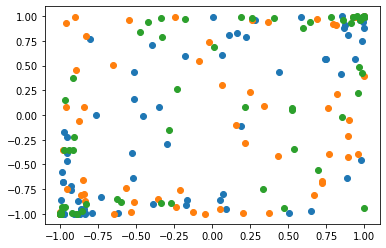

In [93]:

for c in clusters:
    print(np.mean(c, axis=0))
    c = np.array(c).T
    plt.scatter(c[0], c[1])
plt.show()

In [86]:
np.random.randint(0, 3, (200))

array([0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 2, 2, 1, 2, 0, 0, 0,
       2, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 1, 1, 0,
       1, 2, 1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       2, 0, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 2,
       2, 0, 0, 1, 0, 2, 2, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 2,
       0, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0,
       1, 2, 1, 1, 0, 1, 2, 0, 2, 2, 1, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 1, 1,
       0, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 2, 1, 2, 2,
       0, 2])

In [27]:
C = np.dot(A, B)
C.shape


(2,)

In [28]:
C

array([ 55, 145])